<a href="https://colab.research.google.com/github/AndrewstheBuilder/VideoSemanticSearch_JiuJitsu/blob/main/CNN_JiuJitsu_Film.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Training

### Process trainset

In [1]:
!unzip /content/train_subset4k.zip -d /content/trainset

Archive:  /content/train_subset4k.zip
   creating: /content/trainset/dataset/
   creating: /content/trainset/dataset/none/
  inflating: /content/trainset/dataset/none/video_10_frame_5400.jpg  
  inflating: /content/trainset/dataset/none/video_10_frame_2280.jpg  
  inflating: /content/trainset/dataset/none/video_13_frame_17280.jpg  
  inflating: /content/trainset/dataset/none/video_1_frame_20280.jpg  
  inflating: /content/trainset/dataset/none/video_12_frame_7920.jpg  
  inflating: /content/trainset/dataset/none/video_13_frame_6264.jpg  
  inflating: /content/trainset/dataset/none/video_10_frame_37230.jpg  
  inflating: /content/trainset/dataset/none/video_10_frame_11010.jpg  
  inflating: /content/trainset/dataset/none/video_13_frame_0744.jpg  
  inflating: /content/trainset/dataset/none/video_12_frame_10560.jpg  
  inflating: /content/trainset/dataset/none/video_10_frame_0990.jpg  
  inflating: /content/trainset/dataset/none/video_13_frame_1200.jpg  
  inflating: /content/trainset/da

In [2]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
transform = transforms.Compose(
    [ transforms.Resize((64, 64)),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data_path = './trainset/dataset'
train_dataset = datasets.ImageFolder(root=train_data_path, transform=transform)

In [26]:
# Get distribution of training dataset
import os
import pandas as pd

# Dictionary to store the count of samples per class
class_distribution = {}

# Iterate through each subdirectory (class)
for class_name in os.listdir(train_data_path):
    class_path = os.path.join(train_data_path, class_name)

    if os.path.isdir(class_path):
        # Count the number of files (samples) in the class directory
        num_samples = len(os.listdir(class_path))
        class_distribution[class_name] = num_samples

# Convert the dictionary to a pandas DataFrame for better visualization
df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Number of Samples'])

# Sort the DataFrame by number of samples
df = df.sort_values(by='Number of Samples', ascending=False)

df

,Class,Number of Samples
3,pinning,1185
1,standing,1155
2,guarded,974
0,none,686


In [4]:
batch_size = 4 # You can adjust the batch size based on memory availability
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
classes = train_dataset.classes

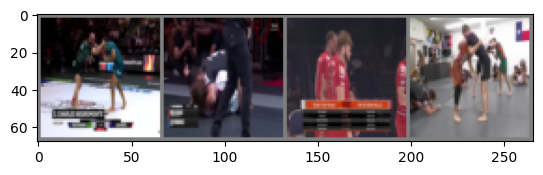

standing pinning none  standing


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
classes = train_dataset.classes

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### Define CNN architecture and Train

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128, 3, padding='same')
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, len(classes))

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
epochs=7

In [8]:
net.train()
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        # for name, param in net.named_parameters():
        #   if param.requires_grad:
        #       print(f'{name} grad: {param.grad.abs().mean()}')
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % batch_size == batch_size-1:    # print every batch_size mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / batch_size:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     4] loss: 1.361
[1,     8] loss: 1.437
[1,    12] loss: 1.274
[1,    16] loss: 1.333
[1,    20] loss: 1.341
[1,    24] loss: 1.345
[1,    28] loss: 1.296
[1,    32] loss: 1.424
[1,    36] loss: 1.230
[1,    40] loss: 1.386
[1,    44] loss: 1.317
[1,    48] loss: 1.324
[1,    52] loss: 1.204
[1,    56] loss: 1.166
[1,    60] loss: 1.135
[1,    64] loss: 1.153
[1,    68] loss: 1.363
[1,    72] loss: 1.054
[1,    76] loss: 0.940
[1,    80] loss: 1.430
[1,    84] loss: 1.294
[1,    88] loss: 1.271
[1,    92] loss: 1.470
[1,    96] loss: 1.015
[1,   100] loss: 1.126
[1,   104] loss: 1.142
[1,   108] loss: 1.166
[1,   112] loss: 0.894
[1,   116] loss: 1.331
[1,   120] loss: 1.093
[1,   124] loss: 1.001
[1,   128] loss: 0.855
[1,   132] loss: 1.147
[1,   136] loss: 1.259
[1,   140] loss: 1.051
[1,   144] loss: 1.276
[1,   148] loss: 0.804
[1,   152] loss: 1.361
[1,   156] loss: 0.949
[1,   160] loss: 1.099
[1,   164] loss: 0.723
[1,   168] loss: 0.905
[1,   172] loss: 1.350
[1,   176] 

In [9]:
print('labels',labels)
classes = train_dataset.classes
print('classes',classes)
t = torch.tensor([[[1, 2],[3, 4]],[[5, 6],[7, 8]]])
print('t.shape',t.shape)
t_flat = torch.flatten(t, 1)
print('t_flat.shape',t_flat.shape)

labels tensor([2, 3, 2, 1])
classes ['guarded', 'none', 'pinning', 'standing']
t.shape torch.Size([2, 2, 2])
t_flat.shape torch.Size([2, 4])


In [10]:
PATH = './kaggle_net.pth'
torch.save(net.state_dict(), PATH)

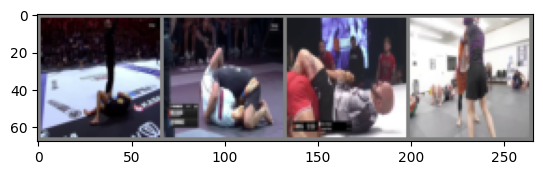

GroundTruth:  standing guarded guarded standing


In [11]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [12]:
net = Net()
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [13]:
outputs = net(images)

In [14]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  standing standing guarded standing


In [15]:
correct = 0
total = 0
# Set the model to evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 training images: {100 * correct // total} %')

Accuracy of the network on the 10000 training images: 91 %


In [16]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# Set the model to evaluation mode
net.eval()

# again no gradients needed
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: guarded is 79.4 %
Accuracy for class: none  is 88.2 %
Accuracy for class: pinning is 97.1 %
Accuracy for class: standing is 98.7 %


## Validate model on test set

### Process Test Set

In [17]:
!unzip /content/testset\(1\).zip -d /content/testset

Archive:  /content/testset(1).zip
  inflating: /content/testset/guarded/frame_1890.jpg  
  inflating: /content/testset/guarded/frame_3240.jpg  
  inflating: /content/testset/guarded/frame_4680.jpg  
  inflating: /content/testset/guarded/frame_4860.jpg  
  inflating: /content/testset/guarded/frame_4950.jpg  
  inflating: /content/testset/guarded/frame_5310.jpg  
  inflating: /content/testset/guarded/frame_5490.jpg  
  inflating: /content/testset/guarded/frame_6480.jpg  
  inflating: /content/testset/guarded/frame_6840.jpg  
  inflating: /content/testset/guarded/frame_6930.jpg  
  inflating: /content/testset/guarded/frame_7200.jpg  
  inflating: /content/testset/guarded/frame_7290.jpg  
  inflating: /content/testset/guarded/frame_8190.jpg  
  inflating: /content/testset/none/frame_0000.jpg  
  inflating: /content/testset/none/frame_0540.jpg  
  inflating: /content/testset/none/frame_0630.jpg  
  inflating: /content/testset/none/frame_0720.jpg  
  inflating: /content/testset/none/frame_10

In [18]:
test_data_path = './testset/'
test_dataset = datasets.ImageFolder(root=test_data_path, transform=transform)
# Collect file paths and their corresponding labels
image_paths = [sample[0] for sample in test_dataset.samples]

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
# Get distribution of data between classes in test set
import os
import pandas as pd

# Dictionary to store the count of samples per class
class_distribution = {}

# Iterate through each subdirectory (class)
for class_name in os.listdir(test_data_path):
    class_path = os.path.join(test_data_path, class_name)

    if os.path.isdir(class_path):
        # Count the number of files (samples) in the class directory
        num_samples = len(os.listdir(class_path))
        class_distribution[class_name] = num_samples

# Convert the dictionary to a pandas DataFrame for better visualization
df = pd.DataFrame(list(class_distribution.items()), columns=['Class', 'Number of Samples'])

# Sort the DataFrame by number of samples
df = df.sort_values(by='Number of Samples', ascending=False)

df

,Class,Number of Samples
3,pinning,64
0,none,53
1,standing,17
2,guarded,13


### Evaluate on test set

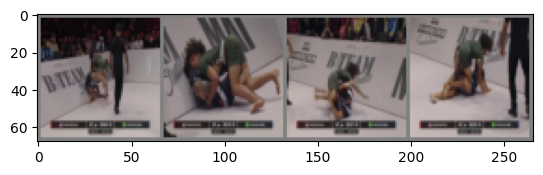

GroundTruth:  guarded guarded guarded guarded


In [19]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [20]:
outputs = net(images)

In [21]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  standing guarded guarded guarded


In [22]:

correct = 0
total = 0
# Set the model to evaluation mode
net.eval()

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 training images: {100 * correct // total} %')

Accuracy of the network on the 10000 training images: 53 %


In [37]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
false_positive = {classname: 0 for classname in classes}
false_negative = {classname: 0 for classname in classes}

# Set the model to evaluation mode
net.eval()

# again, no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            else:
                # False positive: predicted wrong class
                false_positive[classes[prediction]] += 1
                # False negative: missed correct class
                false_negative[classes[label]] += 1

            # Total predictions for each class (both correct and incorrect)
            total_pred[classes[label]] += 1

# Print accuracy, precision, and recall for each class
for classname, correct_count in correct_pred.items():
    # Accuracy
    accuracy = 100 * float(correct_count) / total_pred[classname]

    # Precision: Handle division by zero if no predictions were made for this class
    if correct_count + false_positive[classname] > 0:
        precision = 100 * float(correct_count) / (correct_count + false_positive[classname])
    else:
        precision = 0.0  # No positive predictions for this class

    # Recall: Handle division by zero if no actual instances of the class exist
    if correct_count + false_negative[classname] > 0:
        recall = 100 * float(correct_count) / (correct_count + false_negative[classname])
    else:
        recall = 0.0  # No actual instances for this class

    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    print(f'Precision for class: {classname:5s} is {precision:.1f} %')
    print('')
    # print(f'Recall for class: {classname:5s} is {recall:.1f} %')


Accuracy for class: guarded is 76.9 %
Precision for class: guarded is 18.2 %

Accuracy for class: none  is 62.3 %
Precision for class: none  is 100.0 %

Accuracy for class: pinning is 39.1 %
Precision for class: pinning is 92.6 %

Accuracy for class: standing is 58.8 %
Precision for class: standing is 31.2 %



### Analysis on where the CNN went wrong
- TODO:
1. Make sure training dataset is balanced between classes
2. Calculate accuracy, precision, and recall on test set
3. Create confusion matrix for test set

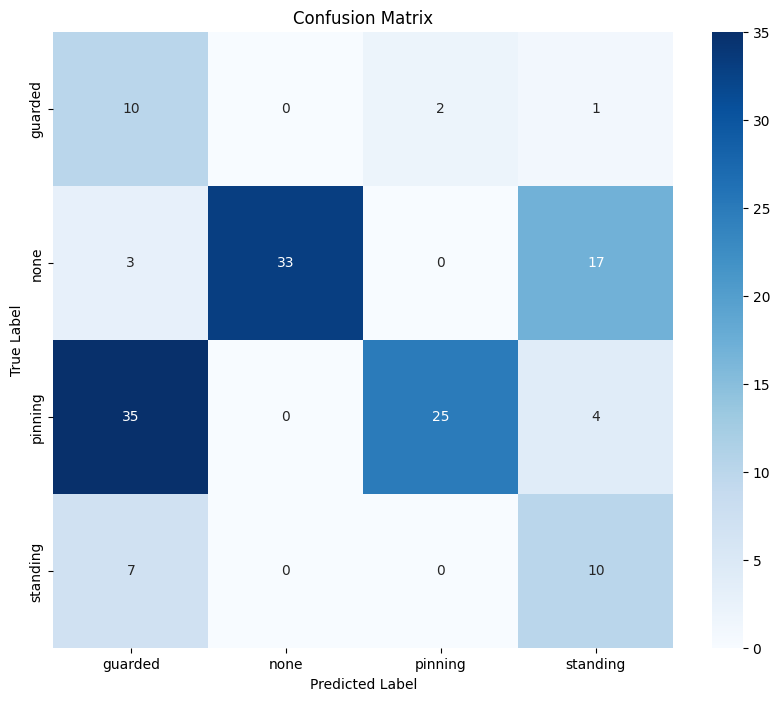

In [38]:
# Confusion Matrix
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `classes` is a list of class names
num_classes = len(classes)
confusion_matrix = torch.zeros(num_classes, num_classes)

# Set the model to evaluation mode
net.eval()

# again, no gradients needed
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)

        # Update the confusion matrix
        for label, prediction in zip(labels, predictions):
            confusion_matrix[label.item(), prediction.item()] += 1

# Convert confusion matrix to numpy for easier visualization
confusion_matrix_np = confusion_matrix.numpy()

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_np, annot=True, fmt="g", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()